# Pronóstico adaptativo

## Descripción del problema real

Los pronósticos de los precios de la electricidad en mercados liberalizados son un insumo fundamental para la toma de decisiones dentro de las organizaciones. Fundamentalmente, los pronosticos de corto plazo son utilizados en decisiones de carácter operativo. En el caso abordado, es necesario contar con los pronósticos para definir la politica de operación de una empresa del sector eléctrico.

## Descripción del problema en términos de los datos

La carpeta `datos/precios/` contiene los precios historicos horarios de la electricidad en la Bolsa de Energía del mercado eléctrico colombiano, publicados por el operador del mercado. Se desean obtener pronósticos para el precio promedio diario para los próximos siete (7) días a la fecha actual.

## Aproximaciones posibles

En este caso, se desea evaluar la capacidad de pronóstico de un ADALINE con aprendizaje en línea.

## Requerimientos

Usted debe:

* Procesar los datos históricos para conformar el conjunto de datos. Los archivos de Excel no pueden ser modificados y actualizados directamente por el operador del sistema. Su código debe leer los archivos y crear la serie de precios promedio diarios de la electricidad.


* Determinar si el modelo debe pronosticar los precios promedios sin ninguna transformación, o si la inclusión de una transformación (logaritmo natural, raíz cúbica, raíz cuadrada, etc) resulta en un incremento de la precisión del pronóstico.


* Generar el pronóstico para los precios de los próximos siete días.


* Preparar el código para que el modelo sea entrenado usando el gradiente y el momentum.


* Determinar cuál es el número óptimo de retardos (observaciones) que el modelo debe considerar hacia atrás para producir el pronóstico.


* Determinar los valores óptimos de la tasa de aprendizaje y el momentum.


# Solución

In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics


In [2]:
files = glob.glob("datos/precios/*")
files.sort()

In [3]:
dataset_frames = []
for filename in files:
    dataframe = pd.read_excel(filename, skiprows=2)
    if dataframe.columns[0] != "Fecha":
        dataframe = pd.read_excel(filename, skiprows=3)
    dataset_frames.append(dataframe)

In [4]:
cols = dataset_frames[0].columns

In [5]:
daily_prices = pd.concat(dataset_frames,ignore_index=True,axis=0, sort=True)
daily_prices = daily_prices[cols]

In [6]:
print(daily_prices.isna().sum())

Fecha     9
0        13
1        13
2        10
3        12
4         9
5         9
6        14
7         9
8        11
9         9
10        9
11        9
12        9
13        9
14       10
15        9
16        9
17        9
18        9
19        9
20        9
21       10
22        9
23       10
dtype: int64


Eliminación de nulos

In [7]:
daily_prices = daily_prices.dropna()
print(daily_prices.isna().sum())

Fecha    0
0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
dtype: int64


In [8]:
daily_prices.head()

,Fecha,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
1,1995-07-21,1.073,1.000,1.000,1.00,1.00,1.000,5.000,6.000,6.000,...,5.000,1.000,1.000,5.000,12.000,16.670,11.929,5.000,1.000,1.000
2,1995-07-22,1.073,1.073,1.000,1.00,1.00,1.073,1.303,1.303,1.303,...,1.073,1.000,1.000,1.000,1.303,2.500,2.500,1.303,1.073,1.073
3,1995-07-23,1.073,1.000,1.000,1.00,1.00,1.000,0.100,1.000,1.000,...,1.000,0.100,0.100,1.000,1.238,1.238,1.238,1.238,1.073,1.000
4,1995-07-24,1.000,1.000,0.990,1.00,1.00,1.073,3.000,3.000,3.000,...,1.073,1.073,3.000,2.000,18.630,22.500,9.256,3.000,1.073,1.000
5,1995-07-25,0.990,0.990,0.989,0.99,0.99,1.073,1.263,1.263,1.263,...,1.073,1.073,1.073,1.073,1.263,1.500,1.263,1.263,1.073,0.990


In [9]:
daily_prices = daily_prices.drop(["Fecha"], axis=1)

Obtenemos la media de los precios diarios y graficamos los valores

In [10]:
mean_prices = daily_prices.mean(axis=1)

In [11]:
mean_prices.head()

1    4.924333
2    1.269500
3    0.953083
4    4.305917
5    1.149167
dtype: float64

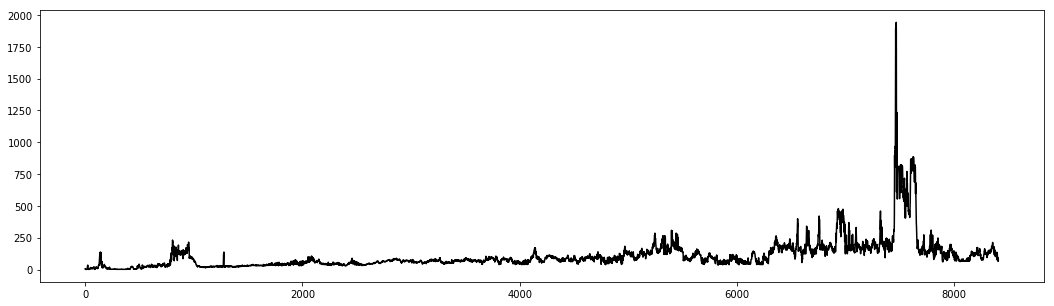

In [12]:
plt.figure(figsize=(18,5))
plt.plot(mean_prices, color='black')
plt.show()

# Red neuronal

In [13]:
import tensorflow as tf
tf.enable_eager_execution()

/home/daniel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [14]:
class Model(object):
    def __init__(self, L):
        self.w = tf.Variable([0.0] * (L+1))

    def __call__(self, x):
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        y_pred = tf.reduce_sum(tf.multiply(self.w, x))
        return y_pred

    def fit(self, mu, x, y_desired):
        y_pred = self(x)
        e = y_desired - y_pred
        x = tf.constant(np.array([1.0] + x, dtype=np.float32))
        self.w.assign_add(tf.scalar_mul(2 * mu * e, x))

In [15]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range = (0, 1))
data_train_scaled = sc.fit_transform(mean_prices.values.reshape(-1,1))
data_train_scaled = [i[0] for i in data_train_scaled.tolist()]

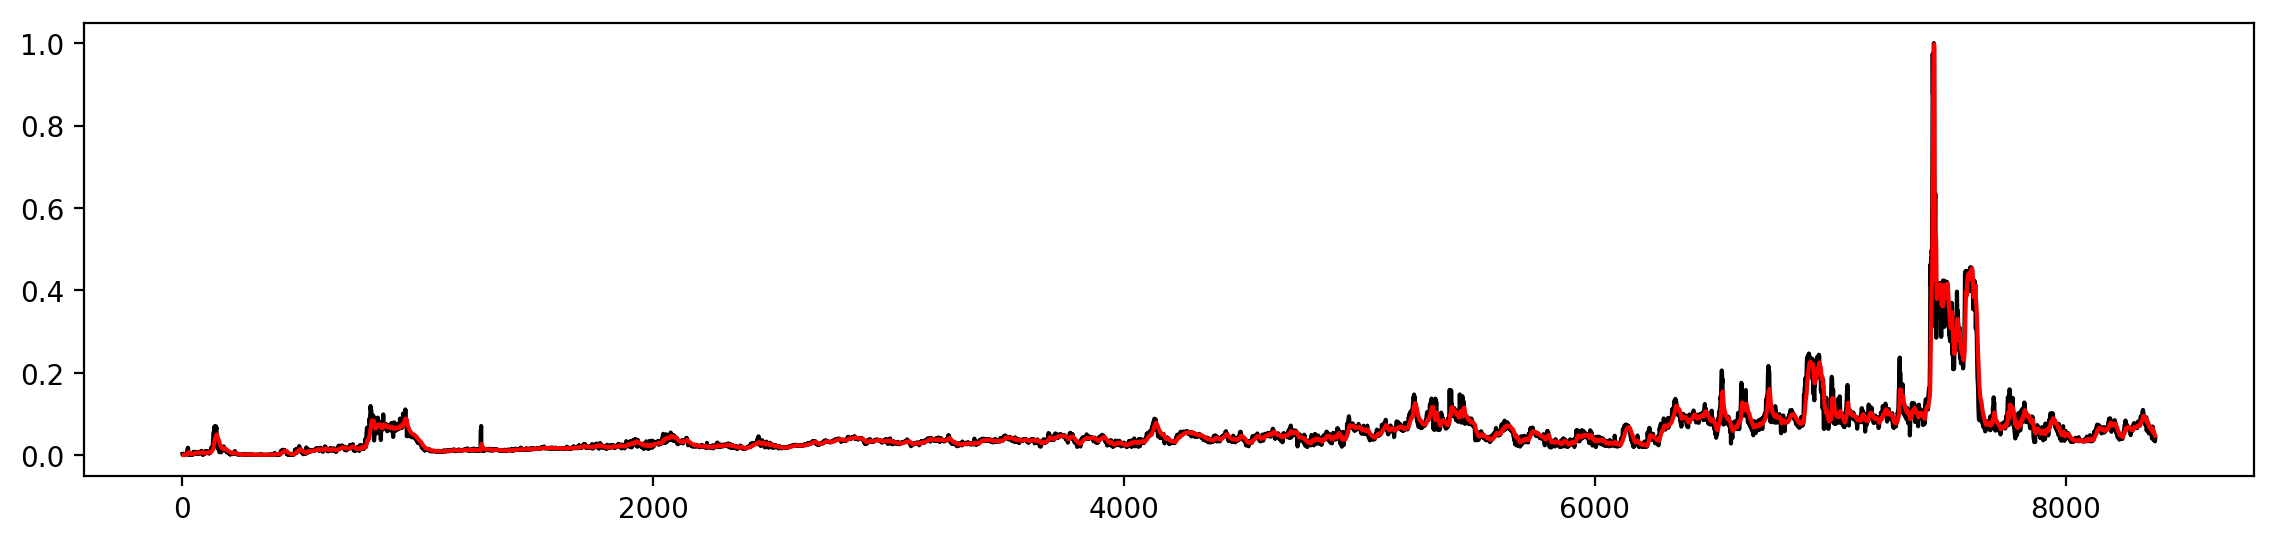

In [16]:
##
##  Para pronosticar el valor actual se toman los `L`
##  valores previos de la serie
##
L = 5

##
##  Modelo
##
model = Model(L)

##
##  Pronosticos del modelo
##
y_pred = np.empty(len(data_train_scaled))
y_pred[:] = np.nan

for t in range(L, len(data_train_scaled)):
    x = data_train_scaled[t-L:t]
    y_pred[t] = model(x)
    model.fit(mu=0.05, x=x, y_desired=data_train_scaled[t])

plt.figure(figsize=(14,3), dpi=200)
plt.plot(data_train_scaled, color='black');
plt.plot(y_pred, color = 'red');

Evaluamos el MSE y el R2 para el mismo modelo con diferentes retardos para obtener el mejor valor para este parametro

In [17]:
retardos = [1,2,3,4,5,6,7,8,9,10]
mse = []
r2 = []
desfase = 24*7
##
##  Para pronosticar el valor actual se toman los `L`
##  valores previos de la serie
##
for retardo in retardos:
    L = retardo

    ##
    ##  Modelo
    ##
    model = Model(L)

    ##
    ##  Pronosticos del modelo
    ##
    y_pred = np.empty(len(data_train_scaled))
    y_pred[:] = np.nan

    for t in range(L, len(data_train_scaled)):
        x = data_train_scaled[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=0.05, x=x, y_desired=data_train_scaled[t])
        
    mse.append(metrics.mean_squared_error(data_train_scaled[-(desfase):], y_pred[-(desfase):]))
    r2.append(metrics.r2_score(data_train_scaled[-(desfase):], y_pred[-(desfase):]))

In [18]:
for r_squared, mean_square, ret in zip(r2, mse, retardos):
    print("\n==========================" + "\nretardo: " + str(ret) + "\nMSE: " + str(mean_square) + "\nr2: " + str(r_squared))



retardo: 1
MSE: 8.612137824819475e-05
r2: 0.6809847473081148

retardo: 2
MSE: 8.318401034182399e-05
r2: 0.6918654970587674

retardo: 3
MSE: 8.725510458807232e-05
r2: 0.6767851397059562

retardo: 4
MSE: 9.215739223460584e-05
r2: 0.6586258328748444

retardo: 5
MSE: 9.726946530095283e-05
r2: 0.639689428067897

retardo: 6
MSE: 0.00010247228289666951
r2: 0.6204168826933443

retardo: 7
MSE: 0.00010769799689355755
r2: 0.6010595232882456

retardo: 8
MSE: 0.00011209000783060364
r2: 0.5847904097718621

retardo: 9
MSE: 0.00011596245038627738
r2: 0.5704459082606015

retardo: 10
MSE: 0.00011866986542586599
r2: 0.5604169617833745


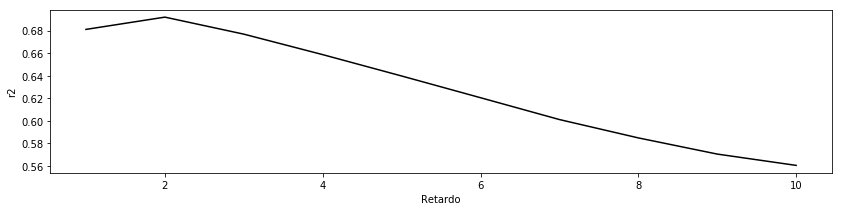

In [19]:
plt.figure(figsize=(14,3))
plt.xlabel("Retardo")
plt.ylabel("r2")
plt.plot(retardos, r2, color='black')


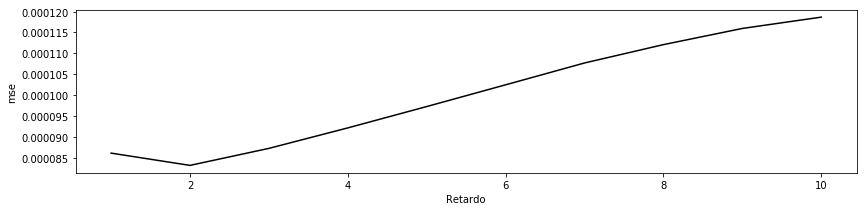

In [20]:
plt.figure(figsize=(14,3))
plt.xlabel("Retardo")
plt.ylabel("mse")
plt.plot(retardos, mse, color='black')

El mejor parametro para los retardos es 2, a continuación haremos lo mismo para la tasa de aprendizaje

In [21]:
mu = [0.0001, 0.001, 0.01, 0.1]
mse = []
r2 = []
desfase = 24*7
##
##  Para pronosticar el valor actual se toman los `L`
##  valores previos de la serie
##
for tasa in mu:
    L = 2

    ##
    ##  Modelo
    ##
    model = Model(L)

    ##
    ##  Pronosticos del modelo
    ##
    y_pred = np.empty(len(data_train_scaled))
    y_pred[:] = np.nan

    for t in range(L, len(data_train_scaled)):
        x = data_train_scaled[t-L:t]
        y_pred[t] = model(x)
        model.fit(mu=tasa, x=x, y_desired=data_train_scaled[t])
        
    mse.append(metrics.mean_squared_error(data_train_scaled[-(desfase):], y_pred[-(desfase):]))
    r2.append(metrics.r2_score(data_train_scaled[-(desfase):], y_pred[-(desfase):]))

In [22]:
for r_squared, mean_square, tasa in zip(r2, mse, mu):
    print("\n==========================" + "\nTasa de aprendizaje: " + str(tasa) + "\nMSE: " + str(mean_square) + "\nr2: " + str(r_squared))



Tasa de aprendizaje: 0.0001
MSE: 0.0003011432328277179
r2: -0.11551030035912624

Tasa de aprendizaje: 0.001
MSE: 0.0012150884529075845
r2: -3.500993339077575

Tasa de aprendizaje: 0.01
MSE: 0.0001423175689752514
r2: 0.4728199182055436

Tasa de aprendizaje: 0.1
MSE: 6.43825694132344e-05
r2: 0.7615107645964044


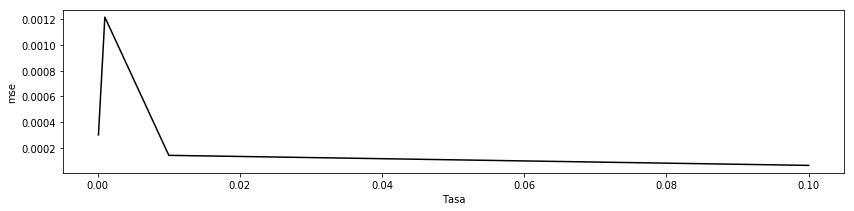

In [23]:
plt.figure(figsize=(14,3))
plt.xlabel("Tasa")
plt.ylabel("mse")
plt.plot(mu, mse, color='black')

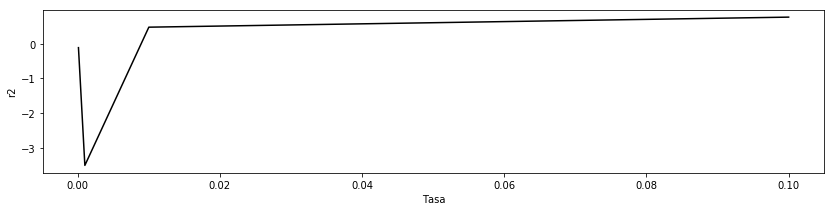

In [24]:
plt.figure(figsize=(14,3))
plt.xlabel("Tasa")
plt.ylabel("r2")
plt.plot(mu, r2, color='black')

Según la prueba con la tasa de aprendizaje y los retardos, la mejor combinación es 2 retardos y tasa de aprendizaje de 0.1.

A continuación modelaremos de nuevo el modelo con estos dos parametros

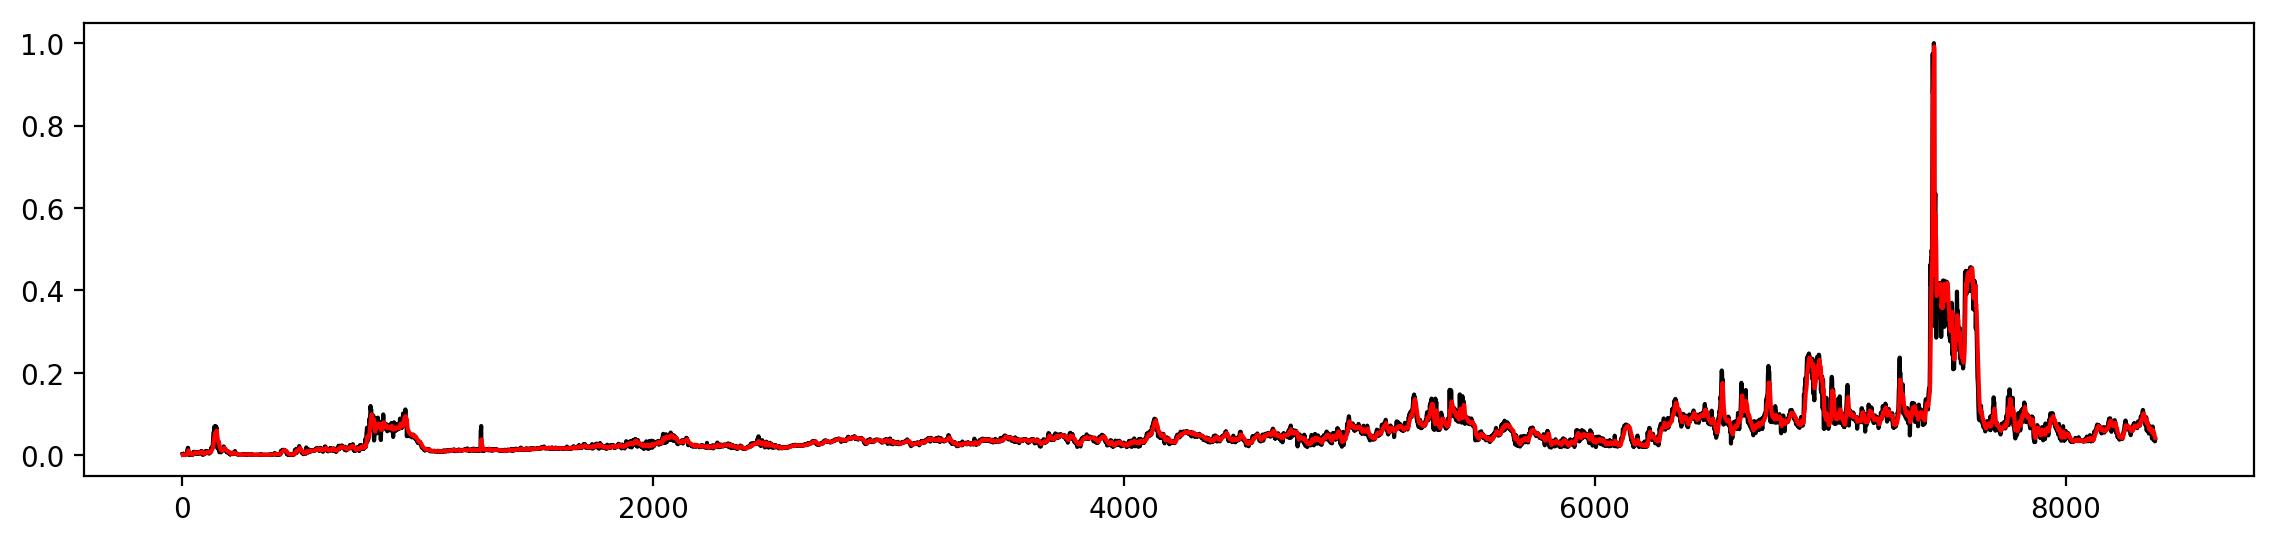

In [25]:
##
##  Para pronosticar el valor actual se toman los `L`
##  valores previos de la serie
##
L = 2

##
##  Modelo
##
model = Model(L)

##
##  Pronosticos del modelo
##
y_pred = np.empty(len(data_train_scaled))
y_pred[:] = np.nan

for t in range(L, len(data_train_scaled)):
    x = data_train_scaled[t-L:t]
    y_pred[t] = model(x)
    model.fit(mu=0.1, x=x, y_desired=data_train_scaled[t])

plt.figure(figsize=(14,3), dpi=200)
plt.plot(data_train_scaled, color='black');
plt.plot(y_pred, color = 'red');